# Reproduzindo as frases no Hugo e treinando rede de analise de sentimentos

## 1 - importando videos do hugo



In [ ]:
!git clone https://github.com/LucaswasTaken/Acessibilidade_Parte_4_Analise_de_Sentimentos_LIBRAS.git

Cloning into 'Acessibilidade_Parte_4_Analise_de_Sentimentos_LIBRAS'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [ ]:
!git clone https://github.com/LucaswasTaken/Acessibilidade_Parte_3_Angulo_dedos.git

Cloning into 'Acessibilidade_Parte_3_Angulo_dedos'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 62 (delta 30), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (62/62), done.


## 2 - Carregando modelo para detecção de mãos em videos

In [ ]:
import cv2
import time
import numpy as np
from google.colab.patches import cv2_imshow

def extract_handposes(video_name):
  protoFile = "/content/Acessibilidade_Parte_3_Angulo_dedos/pose_deploy.prototxt"
  weightsFile = "/content/drive/My Drive/hugo/pose_iter_102000.caffemodel"
  nPoints = 22
  POSE_PAIRS = [ [0,1],[1,2],[2,3],[3,4],[0,5],[5,6],[6,7],[7,8],[0,9],[9,10],[10,11],[11,12],[0,13],[13,14],[14,15],[15,16],[0,17],[17,18],[18,19],[19,20] ]

  threshold = 0.2


  input_source = video_name
  cap = cv2.VideoCapture(input_source)
  hasFrame, frame = cap.read()

  frameWidth = frame.shape[1]
  frameHeight = frame.shape[0]

  aspect_ratio = frameWidth/frameHeight

  inHeight = 368
  inWidth = int(((aspect_ratio*inHeight)*8)//8)

  net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
  k = 0
  total_points = []
  kt = []
  while 1:
      k+=1
      if (k%20!=0):
        continue
      t = time.time()
      hasFrame, frame = cap.read()
      frameCopy = np.copy(frame)
      roi_width = int(frameWidth / 2)
      
      if not hasFrame:
          cv2.waitKey()
          break
      image1 = frameCopy[0:frameHeight, 0:int(roi_width)]
      image2 = frameCopy[0:frameHeight, int(roi_width):int(2*roi_width)]

      inpBlob1 = cv2.dnn.blobFromImage(image1, 1.0 / 255, (roi_width, inHeight),
                                (0, 0, 0), swapRB=False, crop=False)
      inpBlob2 = cv2.dnn.blobFromImage(image2, 1.0 / 255, (roi_width, inHeight),
                                (0, 0, 0), swapRB=False, crop=False)
      net.setInput(inpBlob1)
      output = net.forward()
      # Empty list to store the detected keypoints
      points1 = []

      for i in range(nPoints):
          # confidence map of corresponding body's part.
          probMap = output[0, i, :, :]
          probMap = cv2.resize(probMap, (roi_width, frameHeight))

          # Find global maxima of the probMap.
          minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

          if prob > threshold :
              points1.append((int(point[0]), int(point[1])))
          else :
              points1.append((0,0))
      for elem in points1:
          if(sum(elem)!=0):
            total_points.append(points1)
            kt.append(k)
            # print(k)
            break

      # Empty list to store the detected keypoints
      points2 = []

      for i in range(nPoints):
          # confidence map of corresponding body's part.
          probMap = output[0, i, :, :]
          probMap = cv2.resize(probMap, (roi_width, frameHeight))

          # Find global maxima of the probMap.
          minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

          if prob > threshold :
              points2.append((int(point[0]), int(point[1])))
          else :
              points2.append((0,0))
      for elem in points2:
          if(sum(elem)!=0):
            total_points.append(points2)
            kt.append(k)
            break
      
      key = cv2.waitKey(1)
      if key == 27:
          break

      # print("total = {}".format(time.time() - t))
      # print(total_points)
  return [kt, total_points]


In [ ]:
import json

# vec_tristeza = extract_handposes('/content/Acessibilidade_Parte_4_Analise_de_Sentimentos_LIBRAS/tristezaf.mp4')

# to_json = json.dumps(vec_tristeza)

# with open('/content/drive/My Drive/hugo/tristeza.json', 'w') as file:
#     json.dump(to_json, file)

In [ ]:
# vec_raiva = extract_handposes('/content/Acessibilidade_Parte_4_Analise_de_Sentimentos_LIBRAS/raivaf.mp4')

# to_json= json.dumps(vec_raiva)

# with open('/content/drive/My Drive/hugo/raiva.json', 'w') as file:
#     json.dump(to_json, file)

In [ ]:
alegira_vec = extract_handposes('/content/Acessibilidade_Parte_4_Analise_de_Sentimentos_LIBRAS/alegriaf.mp4')

to_json= json.dumps(alegira_vec)

with open('/content/drive/My Drive/hugo/alegria.json', 'w') as file:
    json.dump(to_json, file)

# 3 - Classificador de Sentimentos

Triiteza dataset

In [51]:
import json
import numpy as np

rs = open("/content/drive/My Drive/hugo/tristeza.json","r").read()

# json.loads(string)
s = json.loads(rs)
tristeza = json.loads(s)
tristeza_index1 = tristeza[0][2:len(tristeza[0]):2]
tristeza_index2 = tristeza[0][0:(len(tristeza[0])-2):2]
tristeza_index = []
for i in range(len(tristeza_index1)):
  tristeza_index.append(tristeza_index1[i]-tristeza_index2[i])
m = np.mean(tristeza_index)
s = np.std(tristeza_index)
index_t = []
for i in range(len(tristeza_index)):
  if(tristeza_index[i]>(m+2*s)):
    index_t.append(i)
tristeza_poses = tristeza[1][2:len(tristeza[0])]
all_seqs = []
all_sentments = []
for i in range(len(index_t)-1):
  all_seqs.append(tristeza_poses[int(2*index_t[i]):int(2*index_t[i+1])])
  all_sentments.append('tristeza')

In [52]:
rs = open("/content/drive/My Drive/hugo/raiva.json","r").read()

# json.loads(string)
s = json.loads(rs)
raiva = json.loads(s)
raiva_index1 = raiva[0][2:len(raiva[0]):2]
raiva_index2 = raiva[0][0:(len(raiva[0])-2):2]
raiva_index = []
for i in range(len(raiva_index1)):
  raiva_index.append(raiva_index1[i]-raiva_index2[i])
m = np.mean(raiva_index)
s = np.std(raiva_index)
index_t = []
for i in range(len(raiva_index)):
  if(raiva_index[i]>(m+2*s)):
    index_t.append(i)
raiva_poses = raiva[1][2:len(raiva[0])]
for i in range(len(index_t)-1):
  all_seqs.append(raiva_poses[int(2*index_t[i]):int(2*index_t[i+1])])
  all_sentments.append('raiva')

In [53]:
rs = open("/content/drive/My Drive/hugo/alegria.json","r").read()

# json.loads(string)
s = json.loads(rs)
alegria = json.loads(s)
alegria_index1 = alegria[0][2:len(alegria[0]):2]
alegria_index2 = alegria[0][0:(len(alegria[0])-2):2]
alegria_index = []
for i in range(len(alegria_index1)):
  alegria_index.append(alegria_index1[i]-alegria_index2[i])
m = np.mean(alegria_index)
s = np.std(alegria_index)
index_t = []
for i in range(len(alegria_index)):
  if(alegria_index[i]>(m+2*s)):
    index_t.append(i)
alegria_poses = alegria[1][2:len(alegria[0])]
for i in range(len(index_t)-1):
  all_seqs.append(alegria_poses[int(2*index_t[i]):int(2*index_t[i+1])])
  all_sentments.append('alegria')

In [54]:
all_sentments_numeric = []
for i in range(len(all_sentments)):
  if(all_sentments[i]=='tristeza'):
    all_sentments_numeric.append(0)
  elif(all_sentments[i]=='raiva'):
    all_sentments_numeric.append(1)
  else:
    all_sentments_numeric.append(2)

In [5]:
np.array(all_seqs[3]).shape

(96, 22, 2)

In [59]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding

class Preprocessing(): 
    def __init__(self,input_libras,sentimentos):
        self.encoded_data = input_libras
        self.classes = sentimentos
        self.max_length = None
        self.sequences = None
        self.sequencesy = None
        self.x = None
        self.y = None
    def generate_sequence(self):
        seq_list = list()
        seq_listy = list()
        for i in range(len(self.encoded_data)):
            item = np.reshape(self.encoded_data[i],(int(len(self.encoded_data[i])*22*2)))
            l = len(item)
            for id in range(1,l,int(l/10 +1)):
                seq_list.append(item[:id+1])
                seq_listy.append(self.classes[i])
        self.max_length = max([len(seq) for seq in seq_list])
        self.sequences = pad_sequences(seq_list, maxlen=self.max_length, padding='pre')
        self.sequences = np.array(self.sequences)
        print(self.sequences)
        self.sequencesy  = seq_listy
    def get_data(self):
        self.x = self.sequences
        self.y = self.sequencesy
        self.y = to_categorical(self.y,num_classes=3)

In [60]:
pr = Preprocessing(all_seqs,all_sentments)
pr.generate_sequence()
pr.get_data()

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0  91 385]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [26]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
class Model():
    def __init__(self):
        self.model = None
        self.history = None
        self.x = None
        self.y = None
        self.input_train = None
        self.input_test = None
        self.output_train = None
        self.output_test = None
        self.max_len = pr.max_length
        
        
    def create_model(self):
        self.model = Sequential()
        self.model.add(LSTM(512, input_shape=(self.max_len,1)))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(128))
        self.model.add(Dense(3,activation='softmax'))
        self.model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        print(self.model.summary())
    def run(self,epochs,batch_size):
        seed = 7
        np.random.seed(seed)
        mcp_save = ModelCheckpoint('class_prediction_model_best_weights.hdf5', save_best_only=True, monitor='val_loss', mode='min')
        self.input_train, self.input_test, self.output_train, self.output_test = train_test_split(self.x, self.y, test_size=0.1, random_state=seed, stratify=self.y)
        self.history = self.model.fit(self.input_train, self.output_train,validation_data=(self.input_test,self.output_test),callbacks=[mcp_save], epochs=epochs,batch_size=batch_size,validation_split=0.1)
        
    def save(self):
        self.model.save("class_prediction_model.h5")

In [27]:
model_obj = Model()
model_obj.x = pr.x
model_obj.y = pr.y
model_obj.create_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 512)               1052672   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 387       
Total params: 1,118,723
Trainable params: 1,118,723
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
model_obj.run(100,100)
model_obj.save()

Epoch 1/100
8/8 [==============================] - 10s 1s/step - loss: 1.2472 - accuracy: 0.3479 - val_loss: 1.1191 - val_accuracy: 0.3214
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 1.1478 - accuracy: 0.3386 - val_loss: 1.1001 - val_accuracy: 0.3810
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 1.1154 - accuracy: 0.3745 - val_loss: 1.0866 - val_accuracy: 0.4048
Epoch 4/100
8/8 [==============================] - 10s 1s/step - loss: 1.0801 - accuracy: 0.3931 - val_loss: 1.0673 - val_accuracy: 0.3929
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 1.0681 - accuracy: 0.4276 - val_loss: 1.0691 - val_accuracy: 0.4524
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 1.0793 - accuracy: 0.4290 - val_loss: 1.0941 - val_accuracy: 0.4405
Epoch 7/100
8/8 [==============================] - 9s 1s/step - loss: 1.0565 - accuracy: 0.4276 - val_loss: 1.0710 - val_accuracy: 0.4286
Epoch 8/100
8/8 [===============

In [44]:
class Prediction():
    def __init__(self,max_len):
        self.model = None
        self.max_length = max_len+1
    
    def load_model(self):
        self.model = load_model("class_prediction_model.h5")
    def predict_words(self,encoded_data,num_words):
        padded_data = pad_sequences([encoded_data],maxlen = self.max_length-1,padding='pre')
        y_preds = self.model.predict(padded_data)
        return y_preds

In [45]:
from tensorflow.keras.models import load_model
pred = Prediction(pr.max_length)    
pred.load_model()

F1 Score:  0.5054828212722949
Accuracy:  0.5053763440860215
Precision:  0.52298064254586


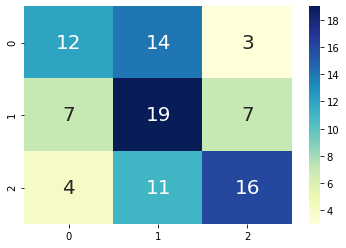

In [46]:
y_pred_class = []
y_real_clas = []
for i in range(len(model_obj.output_test)):
  y_pred = pred.predict_words(model_obj.input_test[i],1)
  y_pred_class.append(np.argmax(y_pred))
  y_real_clas.append(np.argmax(model_obj.output_test[i]))
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

cm = confusion_matrix(y_real_clas, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
print('F1 Score: ', f1_score(y_real_clas, y_pred_class, average='macro'))
print('Accuracy: ', accuracy_score(y_real_clas, y_pred_class))
print('Precision: ', precision_score(y_real_clas, y_pred_class, average='macro'))

# Extraindo n-gramas do texto e utilziando em dados de libras da literatura

In [ ]:
!git clone https://github.com/LucaswasTaken/Acessibilidade_Parte_1_Analise_de_Sentimentos.git

fatal: destination path 'Acessibilidade_Parte_1_Analise_de_Sentimentos' already exists and is not an empty directory.


In [ ]:
pip install unidecode

In [ ]:
import re
import string
from unidecode import unidecode
from tensorflow.keras.models import load_model
from  tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np

class Prediction():
    def __init__(self,tokenizer,max_len):
        self.model = None
        self.tokenizer = tokenizer
        self.idx2word = {v:k for k,v in self.tokenizer.word_index.items()}
        self.max_length = max_len+1
    
    def load_model(self):
        self.model = load_model("/content/Acessibilidade_Parte_1_Analise_de_Sentimentos/scr/class_prediction_model.h5")
        
    def predict_words(self,encoded_data):
        encoded_data = pad_sequences(encoded_data,maxlen = 11 ,padding='pre')
        y_preds = self.model.predict(encoded_data)
        return y_preds

def analise_sentimento(text):
  text = unidecode(text.lower())
  text= re.sub(r'\[[0-9]*\]', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  text = re.sub('[^a-zA-Z]', ' ', text )
  text = re.sub(r'\s+', ' ', text)  
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  clean_text = [text]

  with open('/content/Acessibilidade_Parte_1_Analise_de_Sentimentos/scr/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

  encoded_data = tokenizer.texts_to_sequences(clean_text)

  max_length = 11

  pred = Prediction(tokenizer, max_length)    
  pred.load_model()

  y_pred = pred.predict_words(encoded_data)
  if(np.argmax(y_pred)==0):
    y_pred_class='raiva'
  elif(np.argmax(y_pred)==1):
    y_pred_class='tristeza'
  else:
    y_pred_class='alegria'
  return y_pred_class

In [ ]:
import pandas as pd
data = pd.read_csv('/content/Acessibilidade_Parte_1_Analise_de_Sentimentos/dataset_sentimentos_augmented.csv')

In [ ]:
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
data

,Unnamed: 0,Frase,Sentimento
0,56,detesto trabalhar no verão,raiva
1,119,acho que isso e defeituoso,tristeza
2,30,estimo muito o seu trabalho,alegria
3,154,estávamos em um grande espetáculo,alegria
4,98,me sinto deslocado em sala de aula,tristeza
...,...,...,...
220,127,ele a colocou delicadamente para dormir,alegria
221,67,suba já para o seu quarto!,raiva
222,18,estou aproveitando as ferias,alegria
223,75,como pode ser tão burro?,raiva


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('portuguese')) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from nltk import everygrams
combinador = ' '
grams = []
for i in range(100):
  print(i)
  word_tokens = word_tokenize(data['Frase'].iloc[i]) 
  filtered_sentence = [w for w in word_tokens if not w in stop_words]
  grams_aux = list(everygrams(filtered_sentence, 1, 3))
  grams_candidate = []
  for gram in grams_aux:
    if(analise_sentimento(combinador.join(gram))==data['Sentimento'].iloc[i]):
      grams_candidate.append(gram)
  print(grams_candidate)
  grams.append(grams_candidate)

In [ ]:
data2 = data.iloc[0:100]
data2['n-gramas'] = grams

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
data2 = data2.sort_values(by=['Sentimento']).reset_index(drop=True)

In [ ]:
data2.to_csv('datased_with_ngrams.csv',index=False)

In [ ]:
data2

,Unnamed: 0,Frase,Sentimento,n-gramas
0,140,Estou despreocupado,alegria,"[(Estou,), (despreocupado,), (Estou, despreocu..."
1,13,conclui minha graduação,alegria,"[(conclui,), (graduação,), (conclui, graduação)]"
2,134,vamos aproveitar as férias,alegria,"[(vamos,), (aproveitar,), (férias,), (vamos, a..."
3,41,poderemos completar o projeto hoje!,alegria,"[(poderemos,), (completar,), (projeto,), (hoje..."
4,28,não me preocupo com o que aconteceu,alegria,"[(preocupo,), (aconteceu,), (preocupo, acontec..."
...,...,...,...,...
95,121,a depressão vai me derrubar,tristeza,"[(depressão,), (derrubar,), (depressão, vai), ..."
96,101,"desanimo, raiva, solidão ou vazies, depressão",tristeza,"[(desanimo,), (raiva,), (solidão,), (vazies,),..."
97,197,esta tragédia nos abalará para sempre,tristeza,"[(tragédia,), (abalará,), (tragédia, abalará),..."
98,210,Eu continuo desencorajando você,tristeza,"[(continuo,), (desencorajando,), (continuo, de..."


In [ ]:
!wget https://zenodo.org/record/3229958/files/01Primeira.rar?download=1


--2020-10-14 13:22:23--  https://zenodo.org/record/3229958/files/01Primeira.rar?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1618947734 (1.5G) [application/octet-stream]
Saving to: ‘01Primeira.rar?download=1’

01Primeira.rar?down 100%[===================>]   1.51G  3.57MB/s    in 7m 1s   

2020-10-14 13:29:26 (3.66 MB/s) - ‘01Primeira.rar?download=1’ saved [1618947734/1618947734]



In [ ]:
!wget https://zenodo.org/record/2667329/files/Sinalizador01.zip?download=1

--2020-10-14 13:32:15--  https://zenodo.org/record/2667329/files/Sinalizador01.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4430252522 (4.1G) [application/octet-stream]
Saving to: ‘Sinalizador01.zip?download=1’

Sinalizador01.zip?d 100%[===================>]   4.13G  6.97MB/s    in 12m 33s 

2020-10-14 13:44:51 (5.61 MB/s) - ‘Sinalizador01.zip?download=1’ saved [4430252522/4430252522]



In [ ]:
!wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/

--2020-10-14 13:56:15--  http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/
Resolving arquivos.ouropreto.ifmg.edu.br (arquivos.ouropreto.ifmg.edu.br)... 200.131.68.69
Connecting to arquivos.ouropreto.ifmg.edu.br (arquivos.ouropreto.ifmg.edu.br)|200.131.68.69|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7964 (7.8K) [text/html]
Saving to: ‘index.html’

index.html          100%[===================>]   7.78K  --.-KB/s    in 0s      

2020-10-14 13:56:16 (293 MB/s) - ‘index.html’ saved [7964/7964]



In [ ]:
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/01Pessoa01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/02Espalhar01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/03Copiar01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/04Agarrar01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/05Recolher01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/06Sumir01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/07Olhar01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/08Justo01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/09Verdade01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/10Peso01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/11Justica01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/12Quem01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/13Nada01.rar"
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/14Acreditar01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/15Esquecer01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/16Amar01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/17Angustiado01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/18Comemorar01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/19Rancor01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/20Assembleia01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/21Comparar01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/22Gritar01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/23Falar01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/24Absorver01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/25Engordar01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/26Brigar01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/27Esperto01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/28Brilhar01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/29Empregado01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/30Substituir01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/31Prisao01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/32Televisao01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/33Ontem01.rar
 !wget http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/34Futuro01.rar

--2020-10-14 14:03:34--  http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/01Pessoa01.rar
Resolving arquivos.ouropreto.ifmg.edu.br (arquivos.ouropreto.ifmg.edu.br)... 200.131.68.69
Connecting to arquivos.ouropreto.ifmg.edu.br (arquivos.ouropreto.ifmg.edu.br)|200.131.68.69|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111404462 (106M) [application/rar]
Saving to: ‘01Pessoa01.rar’

01Pessoa01.rar      100%[===================>] 106.24M  8.36MB/s    in 15s     

2020-10-14 14:03:51 (7.02 MB/s) - ‘01Pessoa01.rar’ saved [111404462/111404462]

--2020-10-14 14:03:51--  http://arquivos.ouropreto.ifmg.edu.br/~vca/Base%20de%20dados%20-%20Sinais%20em%20Libras/01Primeira/02Espalhar01.rar
Resolving arquivos.ouropreto.ifmg.edu.br (arquivos.ouropreto.ifmg.edu.br)... 200.131.68.69
Connecting to arquivos.ouropreto.ifmg.edu.br (arquivos.ouropreto.ifmg.edu.br)|200.131.68.69|:80... connected.
HTTP request sent, awaiting response..

In [ ]:
!unrar x /content/01Pessoa01.rar /content/Sinalizador01/